In [11]:
import torch

# 下載並載入 ViT-L/14 權重
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
model.eval().cuda()  # 若有 GPU

from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize(518),
    transforms.CenterCrop(518),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


Using cache found in /home/aibox/.cache/torch/hub/facebookresearch_dinov2_main


In [12]:
import numpy as np

def extract_dino_feature(img_path):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).cuda()
    with torch.no_grad():
        feat = model(x)               # (1, 1024)
    v = feat[0].cpu().numpy()
    return v / np.linalg.norm(v)      # L2-normalize

In [13]:
import os
from tqdm import tqdm

image_dir = "data/scene"  # 你的影像資料夾
image_paths = sorted([
    os.path.join(image_dir, f)
    for f in os.listdir(image_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
])

embeddings = []
for p in tqdm(image_paths):
    embeddings.append(extract_dino_feature(p))
embeddings = np.vstack(embeddings)
print("Feature shape:", embeddings.shape)  # (N, 1024)


100%|██████████| 1289/1289 [04:55<00:00,  4.36it/s]

Feature shape: (1289, 1024)


In [14]:

import faiss

index = faiss.IndexFlatIP(1024)  # cosine similarity
index.add(embeddings)

# 查詢第 0 張影像最相似的 5 張
query = embeddings[0:1]
D, I = index.search(query, 5)

print("Query:", image_paths[0])
print("Top 5 similar images:")
for i, score in zip(I[0], D[0]):
    print(f"  {image_paths[i]}  (similarity={score:.4f})")


Query: data/scene/DJI_20240829093132_0001_D.JPG
Top 5 similar images:
  data/scene/DJI_20240829093132_0001_D.JPG  (similarity=1.0000)
  data/scene/DJI_20240829093134_0002_D.JPG  (similarity=0.9945)
  data/scene/DJI_20240829093136_0003_D.JPG  (similarity=0.9835)
  data/scene/DJI_20240829093138_0004_D.JPG  (similarity=0.9790)
  data/scene/DJI_20240829093140_0005_D.JPG  (similarity=0.9645)


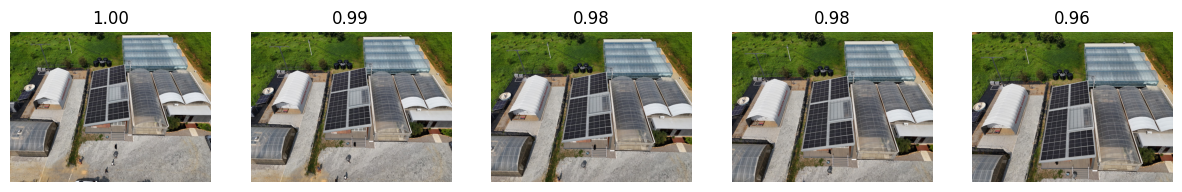

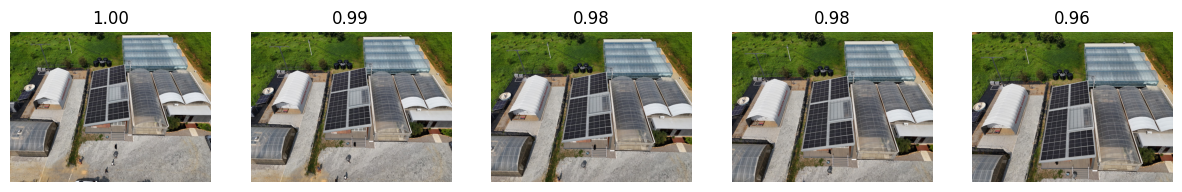

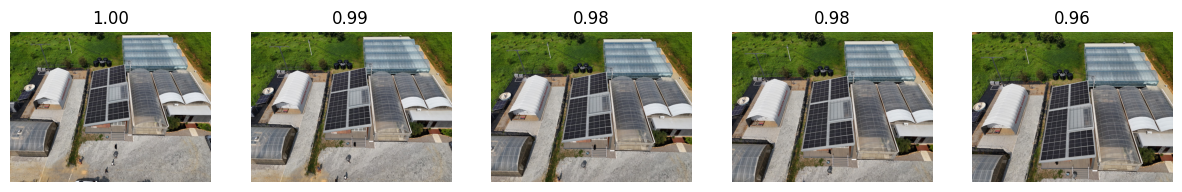

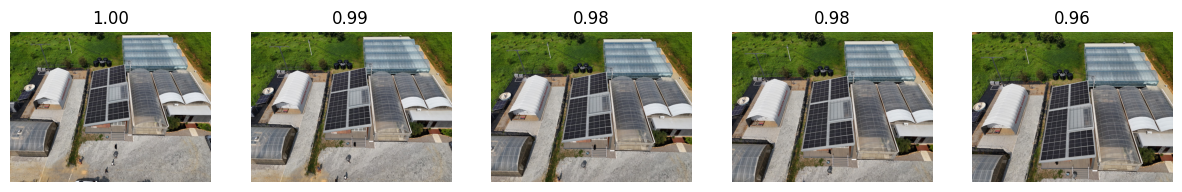

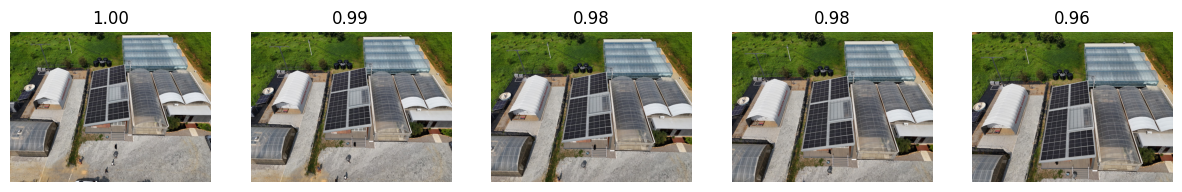

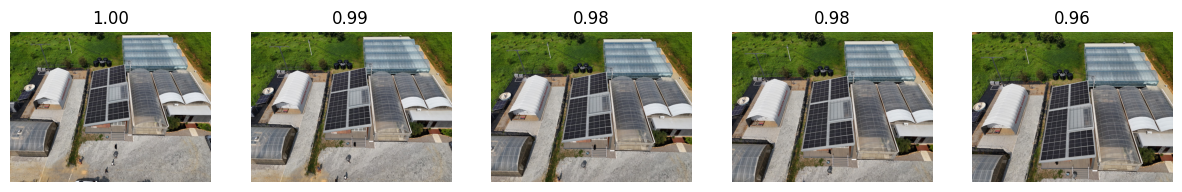

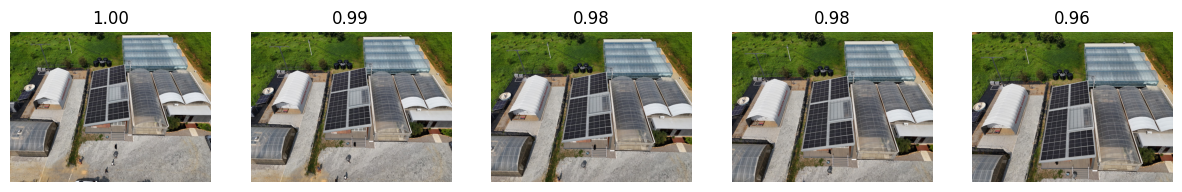

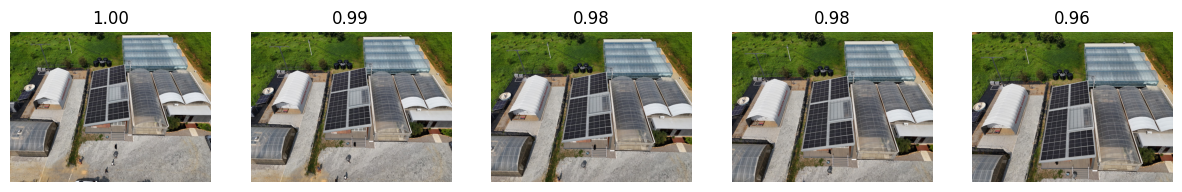

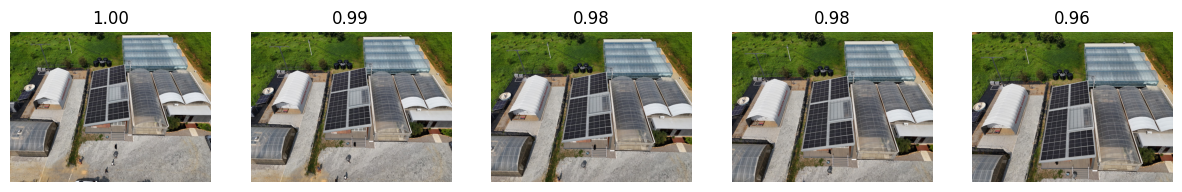

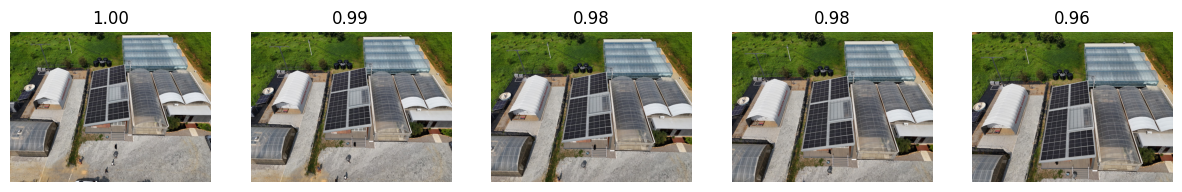

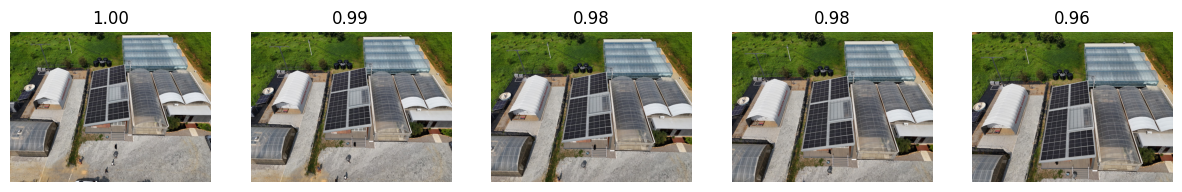

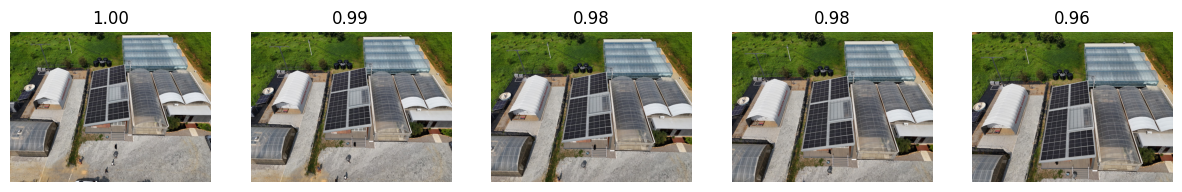

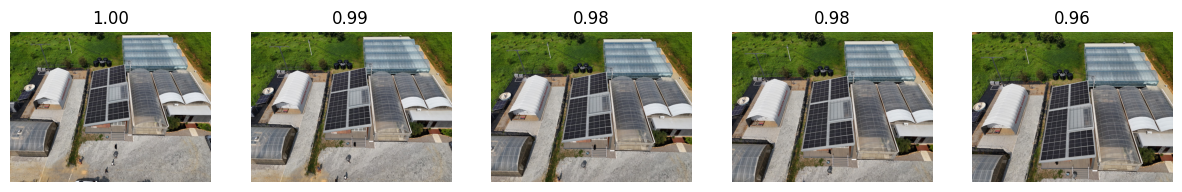

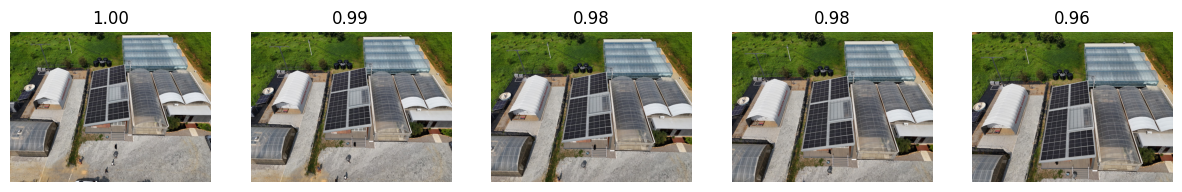

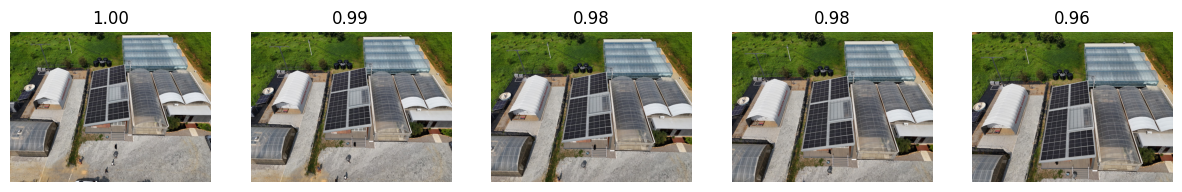

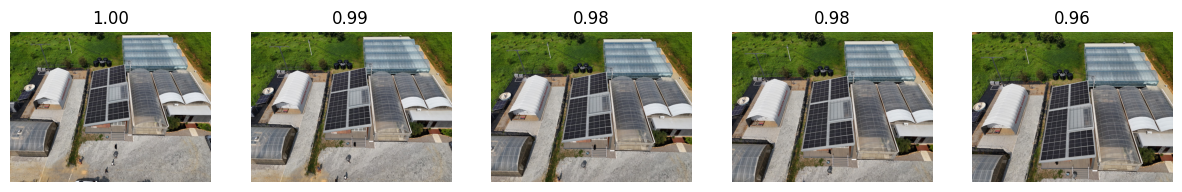

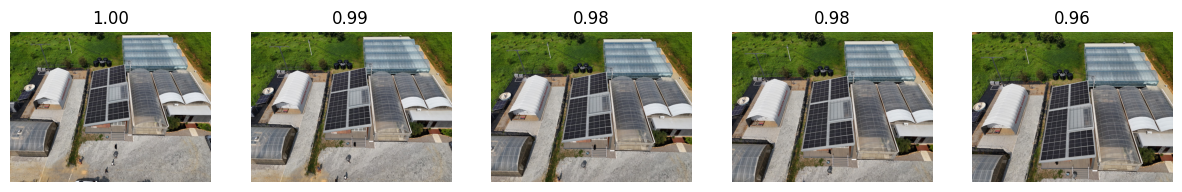

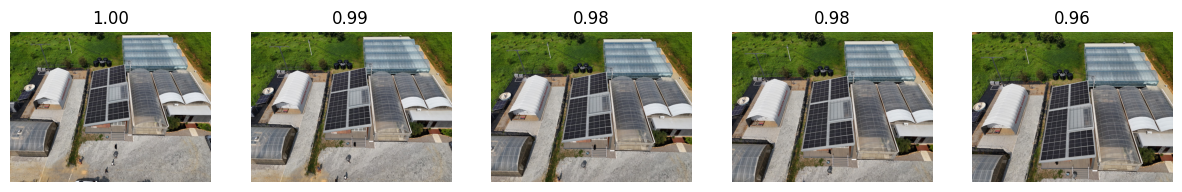

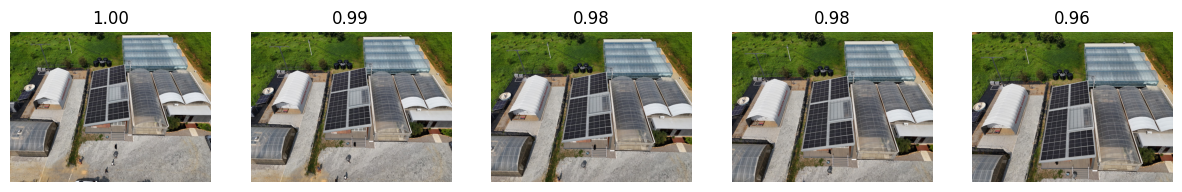

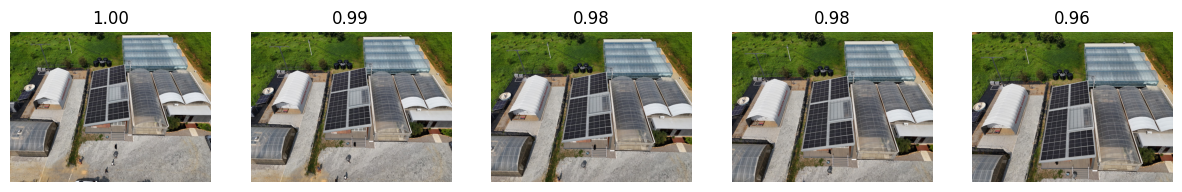

In [15]:
import matplotlib.pyplot as plt

def show_similar_images(query_idx, top_k=5):
    fig, axes = plt.subplots(1, top_k, figsize=(15, 4))
    for j, ax in enumerate(axes):
        img = Image.open(image_paths[I[0][j]])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{D[0][j]:.2f}")
    plt.show()

for i in range(20):
    show_similar_images(i, top_k=5)

similarity_matrix = np.dot(embeddings, embeddings.T)


In [ ]:
import networkx as nx

# === 參數設定 ===
threshold = 0.8  # 相似度閾值，越高連線越少越準確
top_k = 2        # 每個節點連線的最多數量

# === 建立圖 ===
G = nx.Graph()

# 加入節點（每張圖片）
for idx, path in enumerate(image_paths):
    G.add_node(idx, label=os.path.basename(path))

# 根據相似度矩陣加入邊
N = len(image_paths)
for i in range(N):
    # 取 top-k 最相似（排除自己）
    sims = similarity_matrix[i]
    top_idx = sims.argsort()[::-1][1:top_k+1]
    for j in top_idx:
        if sims[j] > threshold:
            G.add_edge(i, j, weight=sims[j])

print(f"Graph nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

Graph nodes: 1289, edges: 3833


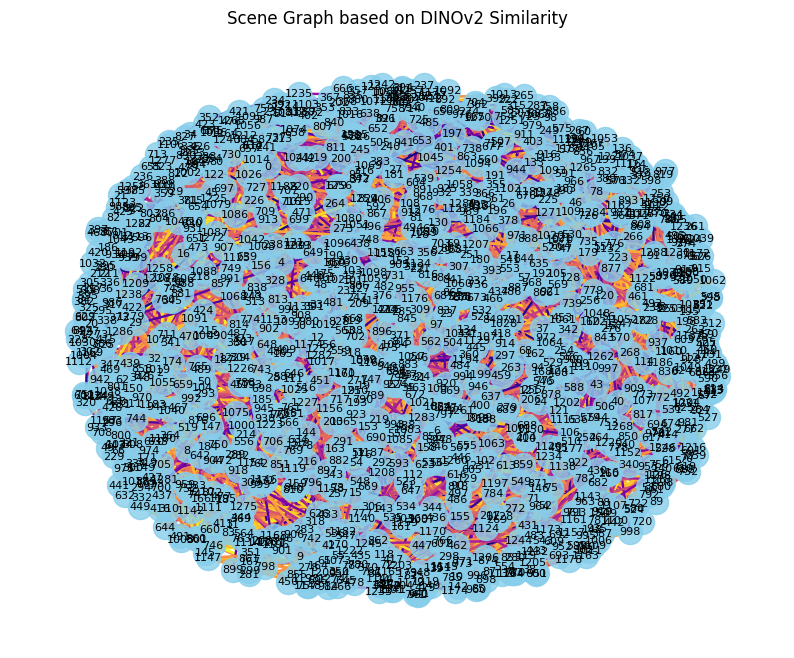

In [17]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# 節點大小與顏色
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue', alpha=0.8)
nx.draw_networkx_labels(G, pos, labels={i: i for i in G.nodes()}, font_size=8)

# 邊根據相似度著色
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges,
                       width=[2*w for w in weights],
                       edge_color=weights, edge_cmap=plt.cm.plasma)

plt.title("Scene Graph based on DINOv2 Similarity")
plt.axis('off')
plt.show()



In [18]:
# 如果圖不連通，只取最大那個子圖
if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    print(f"⚠️ Graph not connected, using largest connected component with {len(G.nodes())} nodes.")


⚠️ Graph not connected, using largest connected component with 1175 nodes.


In [19]:
import networkx as nx

# 把相似度轉成距離（越相似距離越短）
for u, v, d in G.edges(data=True):
    d['distance'] = 1 - d['weight']

# 使用 NetworkX 近似旅行推銷員 (TSP) 路徑
from networkx.algorithms import approximation as approx

tsp_path = approx.traveling_salesman_problem(
    G, 
    weight='distance', 
    cycle=False  # cycle=False 表示不需要回到起點
)

print("📍 Hamiltonian-like Path covering all nodes:")
print(" -> ".join([str(p) for p in tsp_path]))


📍 Hamiltonian-like Path covering all nodes:
1272 -> 1270 -> 1269 -> 1175 -> 1189 -> 552 -> 636 -> 635 -> 634 -> 462 -> 461 -> 460 -> 459 -> 651 -> 652 -> 653 -> 654 -> 305 -> 294 -> 290 -> 293 -> 210 -> 211 -> 212 -> 209 -> 144 -> 147 -> 148 -> 149 -> 150 -> 151 -> 152 -> 159 -> 93 -> 92 -> 91 -> 90 -> 88 -> 50 -> 49 -> 2 -> 3 -> 4 -> 5 -> 7 -> 8 -> 9 -> 10 -> 11 -> 12 -> 13 -> 14 -> 15 -> 16 -> 17 -> 16 -> 15 -> 14 -> 13 -> 12 -> 11 -> 10 -> 9 -> 8 -> 7 -> 5 -> 4 -> 3 -> 2 -> 49 -> 50 -> 88 -> 90 -> 91 -> 92 -> 93 -> 159 -> 152 -> 151 -> 150 -> 149 -> 148 -> 147 -> 144 -> 209 -> 212 -> 211 -> 210 -> 293 -> 290 -> 294 -> 305 -> 654 -> 653 -> 652 -> 651 -> 459 -> 460 -> 461 -> 462 -> 634 -> 635 -> 636 -> 552 -> 1189 -> 1175 -> 1269 -> 1270 -> 1273 -> 1270 -> 1269 -> 1175 -> 1189 -> 552 -> 636 -> 635 -> 634 -> 462 -> 461 -> 460 -> 459 -> 651 -> 652 -> 653 -> 654 -> 305 -> 294 -> 290 -> 293 -> 210 -> 211 -> 212 -> 209 -> 144 -> 147 -> 148 -> 149 -> 150 -> 151 -> 152 -> 159 -> 93 -> 92 -> 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

# 根據路徑順序取得照片
ordered_images = [Image.open(image_paths[i]).convert("RGB") for i in tsp_path]

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(ordered_images[0])
ax.axis("off")
plt.title("Scene Path Traversal (DINOv2 + TSP)")

def update(frame):
    im.set_array(ordered_images[frame])
    ax.set_title(f"Step {frame+1}/{len(ordered_images)} | Image #{tsp_path[frame]}")
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(ordered_images), interval=800, blit=True)
plt.show()
